* * *
<pre> Insea 2025            <i> Statistiques Bayésiennes </i></pre>
* * *


<h1 align="center"> TP7: Bayesian logistic regression for churn prediction </h1>

<pre align="right">                <i> Author: Hicham Janati </i></pre>
* * *


**Objectives:**

- Apply a **Bayesian model** to perform **binary prediction**
- Understand how **Bayesian modeling helps avoid underfitting and overfitting**
- Compare **Bayesian and frequentist approaches**



In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

seed = 42
rng = np.random.default_rng(seed)

## 1. Problem Statement

In companies that offer services (such as a mobile phone operator), **customer retention** is a major challenge. The **churn rate** refers to the percentage of customers who decide to cancel their subscription (e.g., to switch to another provider). If the company can **predict which customers are likely to churn**, it can take proactive steps — such as offering additional services or special deals — to retain them.

We will work with a **real dataset** from a telecom operator (filtered and adapted from: [Kaggle](https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services/data)).


In [246]:
df = pd.read_csv("http://hichamjanati.github.io/data/churn.csv", index_col=0)
df.head()

,Dependents,TechSupport,Contract,InternetService,CustomerID_Region,MonthlyCharges,Months,Churn
0,Yes,No,One year,Fiber optic,MIS-1,78.95,34.0,0
1,Yes,Yes,Two year,DSL,DAL-1,85.95,70.0,0
2,No,Yes,Two year,Fiber optic,SAN-1,104.00,69.0,0
3,No,No internet service,Month-to-month,No,HOU-1,20.55,5.0,0
4,Yes,Yes,Two year,Fiber optic,HOU-1,113.10,72.0,0


In [247]:
df.columns

Index(['Dependents', 'TechSupport', 'Contract', 'InternetService',
       'CustomerID_Region', 'MonthlyCharges', 'Months', 'Churn'],
      dtype='object')

In [248]:
# get the X and y variables
y = df.Churn
X = df.drop("Churn", axis=1)

Check if the number of class instances we have:

In [249]:
y.value_counts()

Churn
0    100
1    100
Name: count, dtype: int64

This binary classification task is balanced: (in practice churn rates are significantly lower, churn prediction is very imbalanced in the real world. I made the problem easier here by resampling from the original data for the sake of simplicity). Let's check the type of data variables we have:

In [250]:
X.dtypes

Dependents            object
TechSupport           object
Contract              object
InternetService       object
CustomerID_Region     object
MonthlyCharges       float64
Months               float64
dtype: object

In [251]:
X.Contract.value_counts()

Contract
Month-to-month    133
One year           37
Two year           30
Name: count, dtype: int64

## 2. Data preprocessing
### 2.1 One-hot encoding / dummy variables
We need to pre-process the data: turn the categorical variables to binary dummy variables. This is called _one-hot encoding_. Here is how it goes:
- for a variable like _Contract_ which takes _Month-to-Month_, _One year_ or _Two year_ (three categories) we can transform it to a 3 binary variables: 

| ... | Contract | ... |
|-----|--------------|-----|
| ... | Month-to-Month | ... |
| ... | One Year | ... |
| ... | Two Year | ... |
| ... | Month-to-Month | ... |
| ... | Two Year | ... |
| ... | Two Year | ... |

↓

| ... | Month-to-Month | One Year | Two Year | ... |
|-----|----------------|-----------|-----------|-----| 
| ... | 1 | 0 | 0 | ... |
| ... | 0 | 1 | 0 | ... |
| ... | 0 | 0 | 1 | ... |
| ... | 1 | 0 | 0 | ... |
| ... | 0 | 0 | 1 | ... |
| ... | 0 | 0 | 1 | ... |

These binary variables are called _dummy variables_ or the one-hot encoding of _Contract_.
However you can notice that the sum of these columns will always be 1: the 3 binary variables are linearly dependent which is bad for linear models (particularly if no regularization is used), this is called a _dummy variables trap_. We should drop one of the columns to avoid it. Thus, a categorical variable with K categories is transformed into K-1 binary variables. We can do this with sklearn _transformer_ object called _OneHotEncoder_:


In [252]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(df[["Contract"]])
encoded_data

<200x2 sparse matrix of type '<class 'numpy.float64'>'
	with 67 stored elements in Compressed Sparse Row format>

The output is a sparse matrix (CSR) which is a compressed form of storing matrices with lots of zeros: instead of storing all their entries, we only store in memory necessary information (for e.g the triplets (i, j, v) such that M[i, j] = v and v is not zero). Here the data is small, no need to used sparse matrices: 

In [253]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(X[["Contract"]])
encoded_data[:10]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.]])

We can apply this to all categorical variables: 

In [254]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_features = ["Dependents", "TechSupport", "Contract", "InternetService", "CustomerID_Region"]
encoded_data = encoder.fit_transform(X[categorical_features])
encoded_data[:10]

array([[1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

But later we will have a regression coefficient for each one of these columns, how do we know which one belongs to which ?
Well we can get their names from the encoder:

In [255]:
encoder.get_feature_names_out(categorical_features)

array(['Dependents_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'Contract_One year', 'Contract_Two year',
       'InternetService_Fiber optic', 'InternetService_No',
       'CustomerID_Region_CHI-1', 'CustomerID_Region_DAL-1',
       'CustomerID_Region_HOU-1', 'CustomerID_Region_LAX-1',
       'CustomerID_Region_MIA-1', 'CustomerID_Region_MIS-1',
       'CustomerID_Region_NYC-1', 'CustomerID_Region_PHL-1',
       'CustomerID_Region_PHX-1', 'CustomerID_Region_SAN-1',
       'CustomerID_Region_SEA-1'], dtype=object)

### 2.2 Scaling numerical features
We also have continuous variables (numerical features): _Months_ and _MonthlyCharges_. As explained in the last class, it's important for them to have the same scale (order of magnitude) in a linear model. Scaling a variable means centering it and dividing by its standard deviation:

In [256]:
variable = X["Months"]
variable = variable - variable.mean()
variable = variable / variable.std()
variable.head()

0    0.326288
1    1.850800
2    1.808453
3   -0.901791
4    1.935495
Name: Months, dtype: float64

It is tedious to do this for each variable, the best way to do it is to use a sklearn _transformer_ called _StandardScaler_:

In [257]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ["MonthlyCharges", "Months"]
scaled_data = scaler.fit_transform(X[numeric_features])
scaled_data[:10]

array([[ 0.37846895,  0.32710679],
       [ 0.63721955,  1.85544479],
       [ 1.30442645,  1.81299095],
       [-1.78025031, -0.90405438],
       [ 1.64080222,  1.94035245],
       [ 0.56698725, -1.03141588],
       [ 1.37835519,  0.58182979],
       [ 1.04937229,  0.66673745],
       [ 0.19734354, -0.77669288],
       [ 0.79062169, -0.73423905]])

### 2.3 Merging both in one transformer:
We can handle both categorical and numerical features in one _ColumnTransformer_ object:

In [258]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ["Dependents", "TechSupport", "Contract", "InternetService", "CustomerID_Region"]
numeric_features = ["MonthlyCharges", "Months"]

categorical_transformer = OneHotEncoder(drop="first", sparse_output=False)
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ],
)

transformed_data = preprocessor.fit_transform(X)
print(f"The shape of the transformed data is {transformed_data.shape}")

# we construct a new pandas with the column names:
column_names = preprocessor.get_feature_names_out()
transformed_df = pd.DataFrame(transformed_data, columns=column_names)
transformed_df.head()

The shape of the transformed data is (200, 20)


,cat__Dependents_Yes,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__Contract_One year,cat__Contract_Two year,cat__InternetService_Fiber optic,cat__InternetService_No,cat__CustomerID_Region_CHI-1,cat__CustomerID_Region_DAL-1,cat__CustomerID_Region_HOU-1,cat__CustomerID_Region_LAX-1,cat__CustomerID_Region_MIA-1,cat__CustomerID_Region_MIS-1,cat__CustomerID_Region_NYC-1,cat__CustomerID_Region_PHL-1,cat__CustomerID_Region_PHX-1,cat__CustomerID_Region_SAN-1,cat__CustomerID_Region_SEA-1,num__MonthlyCharges,num__Months
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.378469,0.327107
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637220,1.855445
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.304426,1.812991
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.780250,-0.904054
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640802,1.940352


### 2.4 Preprocessing and the train-test split
But when developing a machine learing model, we always follow the train-test paradigm where we split train-test data: therefore when transforming / encoding / scaling the variables we should only be using the train data. Otherwise info from the test data will be used by the model: for example, the scaling operation will use test samples to compute the mean and std. Therefore, the column transformer object should be _fit_ on the train only, then we use the _transform_ method on the test data:

In [259]:
from sklearn.model_selection import train_test_split

categorical_features = ["Dependents", "TechSupport", "Contract", "InternetService", "CustomerID_Region"]
numeric_features = ["MonthlyCharges", "Months"]

categorical_transformer = OneHotEncoder(drop="first", sparse_output=False)
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ],
)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

# we get the column names:
column_names = preprocessor.get_feature_names_out()


## 3. Logistic regression 
We can now start doing ML models. First, we use logistic regression without regularization:

#### 3.1 Without regularization

In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# we can fit the logistic regression model with no regularization:
model = LogisticRegression(penalty=None)
model.fit(X_train_processed, y_train.values)

y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Evaluate the model accuracy
print(f"Training accuracy: {accuracy_score(y_train_pred, y_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test_pred, y_test):.4f}")

Training accuracy: 0.8357
Test accuracy: 0.6500


We can see that the model isn't quite good:
1. 83% accuracy on the training data means that the model isnt complex enough to predict labels it has already seen
2. 65% accuracy on the test data suggest a big difference between train and test: the models learns a bit of noise in the training data

We can extract the coefficients and visualize their values:

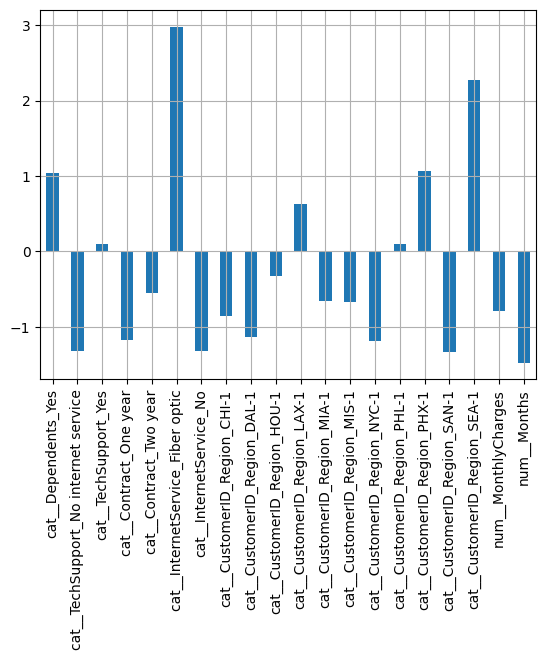

In [261]:
coef = pd.DataFrame(model.coef_, columns=column_names)
coef.T.plot(kind="bar", legend=False)
plt.grid()
plt.show()

We can extract the change in the odd-ratios and visualize their importance in percentages (see TD6):

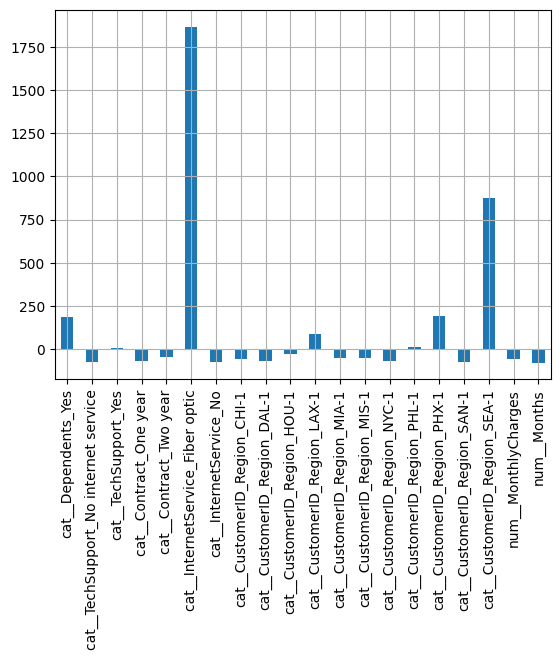

In [262]:
odds_changes = (np.exp(model.coef_) - 1) * 100
coef = pd.DataFrame(odds_changes, columns=column_names)
coef.T.plot(kind="bar", legend=False)
plt.grid()
plt.show()


In [263]:
odds_changes

array([[ 184.33978368,  -73.24588216,   10.11408019,  -69.01164118,
         -42.3604937 , 1867.04450222,  -73.24588216,  -57.30827598,
         -67.89164809,  -27.90134379,   87.71595551,  -47.99574828,
         -49.09364831,  -69.35050994,   10.37215112,  190.19346862,
         -73.42643779,  875.62186833,  -54.79865072,  -77.0485994 ]])

In [264]:
X["Months"].std(), X["MonthlyCharges"].std()


(23.61410818827673, 27.120965039260753)

Some odd percentage changes are off-the-charts ! 1867% increase with Optic Fiber and 875% if the customer is in the region SEA-1 ! Given that the performance of the model is poor here and the coefficient values are very large it is very likely the model has learned noise: regularization is needed.

### 3.2 With L2 / L1 regularization
We can now try to improve the model by adding regularization. We can use the `LogisticRegressionCV` class which will automatically find the best regularization parameter for us:

In [265]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# we can fit the logistic regression model with no regularization:
model = LogisticRegressionCV(Cs=np.logspace(-3, 3, 100), penalty="l2")
model.fit(X_train_processed, y_train.values)

y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Evaluate the model accuracy
print(f"Training accuracy: {accuracy_score(y_train_pred, y_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test_pred, y_test):.4f}")

Training accuracy: 0.7857
Test accuracy: 0.7167


The test accuracy is slightly improved. The coefficients look very similar: 

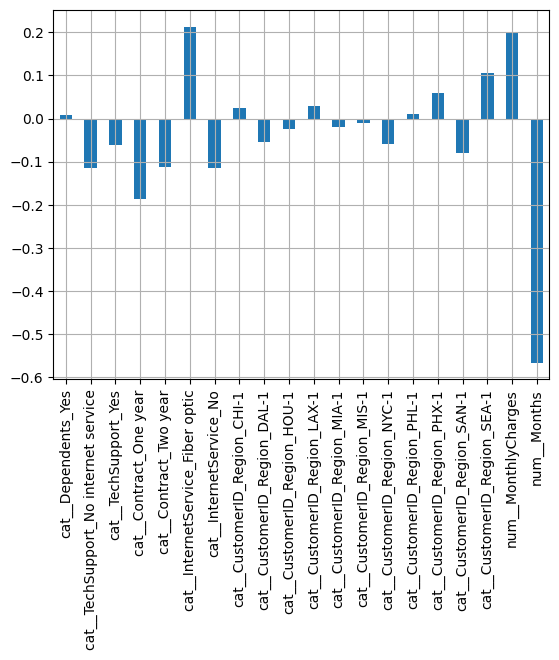

In [266]:
coef = pd.DataFrame(model.coef_, columns=column_names)
coef.T.plot(kind="bar", legend=False)
plt.grid()
plt.show()

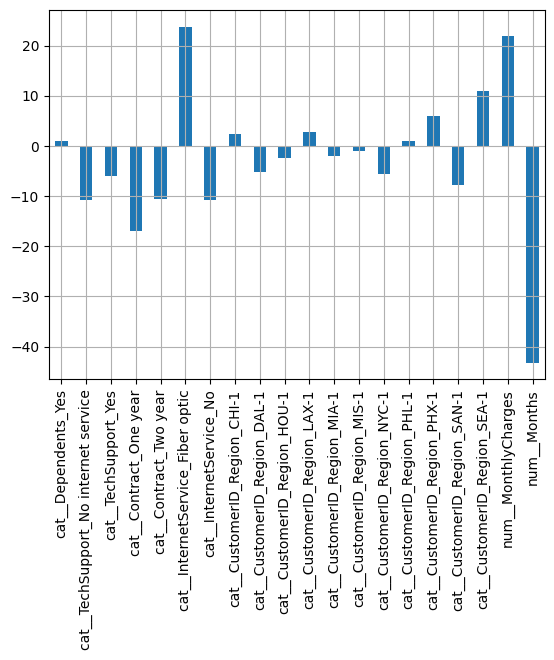

In [267]:
odds_changes = (np.exp(model.coef_) - 1) * 100
coef = pd.DataFrame(odds_changes, columns=column_names)
coef.T.plot(kind="bar", legend=False)
plt.grid()
plt.show()


In [268]:
X["Months"].std(), X["MonthlyCharges"].std()

(23.61410818827673, 27.120965039260753)

These values are more reasonable ! 
We can see that the most impactful features are the contract type, months, the monthly charges, internetService with Fiber optic and the SEA-1 region:
1. the longer the subscription (contract type and months) the less likely the customer churns.
2. In particular, for each additional "months std" = 23.6 months -> -45% odds.
3. having a Fiber optic internet / high charges makes the customer more likely to churn
4. In particular, 26% higher odds of churning if the customer has fiber: it could perhaps more competitiveness between providers.
5. For each additional 27$ per month, the customer odds of churning increase by 23.65%.
6. Finally, being in SEA-1 increases the odds by 11%.



We can also try L1 regularization for sparse coefficients (feature selection):

In [269]:
model = LogisticRegressionCV(Cs=np.logspace(-4, 4, 100), penalty="l1", solver="liblinear")
model.fit(X_train_processed, y_train.values)

y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Evaluate the model accuracy
print(f"Training accuracy: {accuracy_score(y_train_pred, y_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test_pred, y_test):.4f}")

Training accuracy: 0.8429
Test accuracy: 0.6667


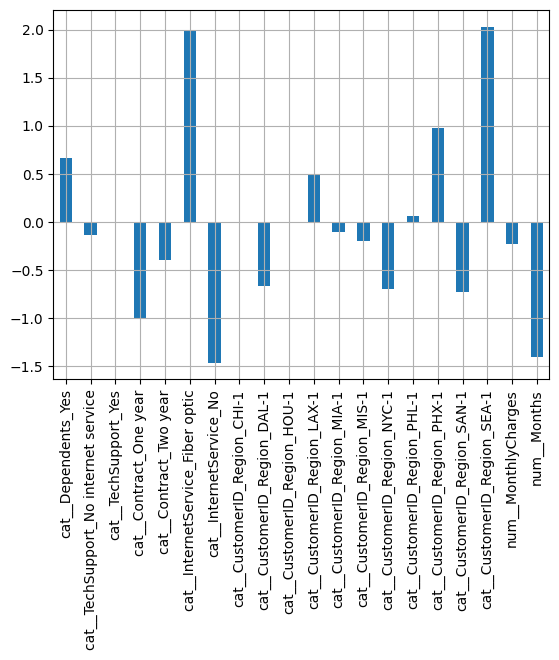

In [270]:
coef = pd.DataFrame(model.coef_, columns=column_names)
coef.T.plot(kind="bar", legend=False)
plt.grid()
plt.show()

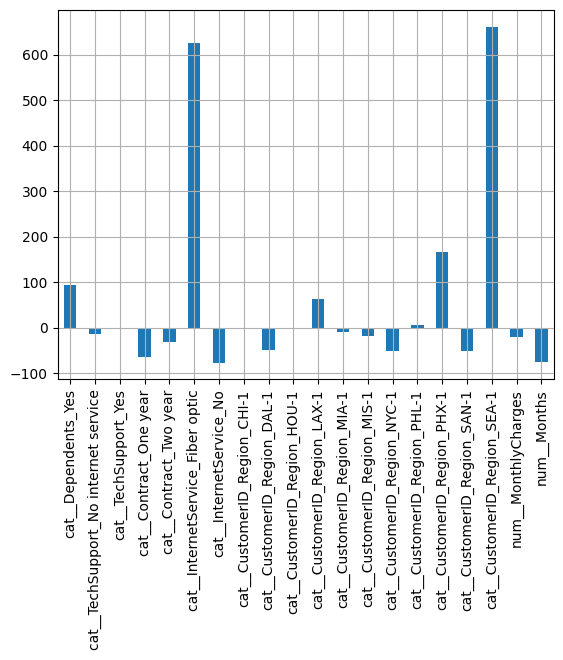

In [271]:
coef = pd.DataFrame(100 * (np.exp(model.coef_) - 1), columns=column_names)
coef.T.plot(kind="bar", legend=False)
plt.grid()
plt.show()

The model is similar to the unregularized case, we have 20 dimension with 100 observations: perhaps using feature selection is not a good idea here since the dimension is not that large compared to the number of observations: the Lasso keeps the largest coefficients and reduces the others to near 0. 

With all these models, we can obtain the prediction probability (sigmoid) of 10 samples for e.g using:

In [272]:
model.predict_proba(X_test_processed[:10])

array([[0.22842486, 0.77157514],
       [0.29932415, 0.70067585],
       [0.22107175, 0.77892825],
       [0.45511437, 0.54488563],
       [0.28544249, 0.71455751],
       [0.85739176, 0.14260824],
       [0.67825299, 0.32174701],
       [0.91052171, 0.08947829],
       [0.78664728, 0.21335272],
       [0.50537597, 0.49462403]])

The sigmoid probability of the model corresponds to the second column of the output above.

It outputs a vector of probabilites that sums to 1. We get the prediction class using the argmax or comparing the second column to 0.5:

In [273]:
model.predict_proba(X_test_processed[:10]).argmax(axis=1)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [274]:
(model.predict_proba(X_test_processed[:10])[:, 1] > 0.5).astype(int)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

## 4. Bayesian logistic regression
We can now build a bayesian logistic regression with a Gaussian prior using pymc:

### 4.1 Fitting the model with MCMC

In [275]:
import pymc as pm
import arviz as az
import seaborn as sns

# Build the model
n_mcmc_samples = 1000
coords = dict(var_names=column_names)
with pm.Model(coords=coords) as logistic_model:
    # Priors for weights and intercept
    sigma = pm.HalfCauchy('sigma', beta=1)
    intercept = pm.Normal('intercept', mu=0, sigma=sigma)
    betas = pm.Normal('betas', mu=0, sigma=sigma, shape=X_train_processed.shape[1])
    
    # Linear predictor
    mu = pm.math.dot(X_train_processed, betas) + intercept
    
    # Likelihood (observed outcome)
    theta = pm.math.sigmoid(mu)
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y_train)
    
    # Sample from posterior
    trace = pm.sample(n_mcmc_samples, tune=1000, return_inferencedata=True)
az.summary(trace)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.288,0.438,-1.101,0.542,0.008,0.007,2776.0,2395.0,1.0
betas[0],0.345,0.487,-0.564,1.270,0.008,0.007,4078.0,2611.0,1.0
betas[1],-0.544,0.733,-1.884,0.875,0.012,0.011,3709.0,2799.0,1.0
betas[2],-0.066,0.457,-0.935,0.788,0.007,0.007,4514.0,2947.0,1.0
betas[3],-0.838,0.554,-1.978,0.110,0.009,0.007,3821.0,3307.0,1.0
betas[4],-0.381,0.634,-1.627,0.768,0.009,0.009,4762.0,3000.0,1.0
betas[5],1.041,0.618,-0.081,2.221,0.014,0.010,2181.0,2661.0,1.0
betas[6],-0.527,0.751,-1.927,0.908,0.012,0.011,3877.0,2795.0,1.0
betas[7],-0.058,0.688,-1.452,1.156,0.010,0.011,4470.0,2692.0,1.0
betas[8],-0.581,0.590,-1.675,0.533,0.010,0.008,3326.0,3316.0,1.0


No warnings, all rhats are equal to 1, the ESS are all very large, no red flags of divergences. the MCMC chains pass all diagnostics. To intepret the coefficients, we should check the HDI of the coefficients, if they contain 0 it means that 0 is included in the 94% credible interval: therefore the coefficient is not statistically different from 0:

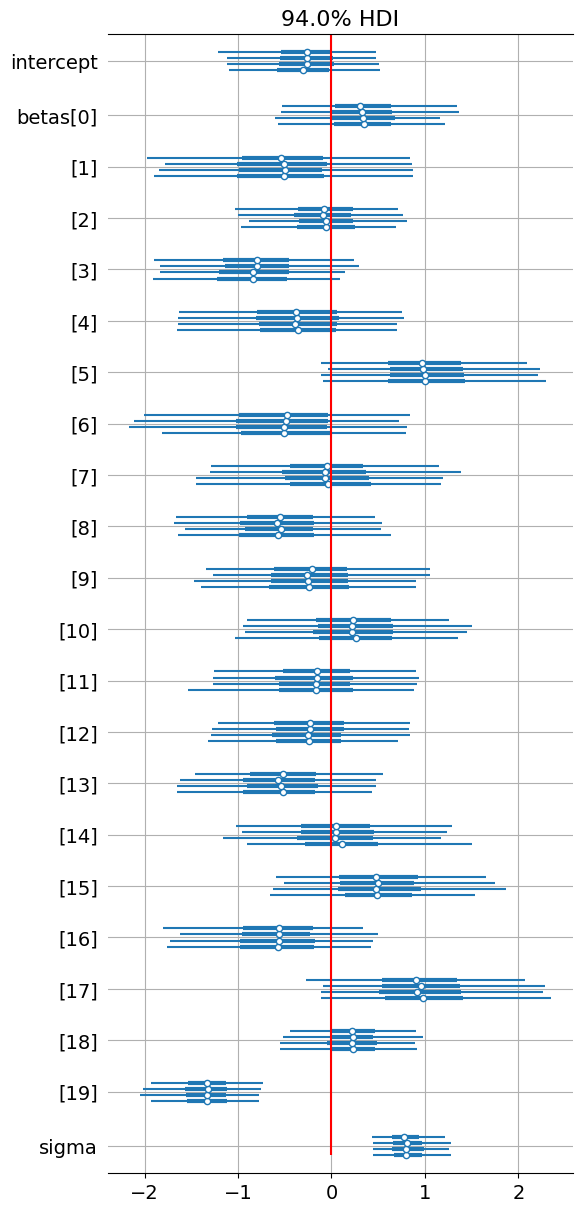

In [276]:
az.plot_forest(trace)
plt.grid()
plt.vlines(0, 0, ymax=100, color="red")
plt.show()

None of them are except sigma and beta[19] which corresponds to the last variable "Months"

In [277]:
column_names[19]

'num__Months'

In [278]:
100 * (np.exp(-1.352) - 1)

-74.127770174036

### 4.2 Making predictions
How do we make predictions with this model ? Well, we can use the MCMC samples (beta) to compute the sigmoid probabilities on the test data:

In [279]:
beta_samples = trace.posterior["betas"].values.reshape(-1, 20)
beta_samples.shape

(4000, 20)

In [280]:
intercept_samples = trace.posterior["intercept"].values.reshape(-1, 1)
intercept_samples.shape

(4000, 1)

In [281]:
from scipy.special import expit as sigmoid

def get_bayes_probas(X, trace):
    beta_samples = trace.posterior["betas"].values.reshape(-1, 20)
    # vector of size 4000 x 20
    intercept_samples = trace.posterior["intercept"].values.reshape(1, -1)
    # vector of size 4000 x 1

    # X test is of size n_samples x 20 so we transpose beta_samples to have a size 20 x 4000
    # then we transpose the output to be 4000 x n_samples compatible with intercept_samples of size 1 x 4000
    logits = X.dot(beta_samples.T) + intercept_samples
    # we have a vector of size n_samples x 4000
    return sigmoid(logits)

probas_bayes_train = get_bayes_probas(X_train_processed, trace)
probas_bayes_test = get_bayes_probas(X_test_processed, trace)

probas_bayes_train.shape, probas_bayes_test.shape


((140, 4000), (60, 4000))

We have 4000 different predictions for each of the 60 test samples, we can compute the average prediction and the standard deviation to evaluate our uncertainty:

In [282]:
mean_proba_bayes_train = probas_bayes_train.mean(axis=1)
std_proba_bayes_train = probas_bayes_train.std(axis=1)

mean_proba_bayes_test = probas_bayes_test.mean(axis=1)
std_proba_bayes_test = probas_bayes_test.std(axis=1)

bayes_predictions_train = (mean_proba_bayes_train > 0.5).astype(int)
bayes_predictions_test = (mean_proba_bayes_test > 0.5).astype(int)

print(f"Training accuracy: {accuracy_score(y_train, bayes_predictions_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, bayes_predictions_test):.4f}")


Training accuracy: 0.8071
Test accuracy: 0.6833


It seems like the performance is similar or even a bit worse than the frequentist approach (Ridge). Why go through the trouble of MCMC then ? Well, because we can compute also uncertainties around those mean predictions of the MCMC samples. For example, with the frequentist approach we would get the the probability of churn is 0.8. With the bayesian approach we have 4000 probabilities of churn for each sample, assume their mean is identical: 0.8. With the 4000 MCMC samples we can also compute an HDI of those probabilities. If the HDI is too large say [0.3, 1.] then we cannot say for sure that 0.8 is statistically significant. If however the HDI is [0.7, 0.9] (it is far from 0.5) then we are more confident in our prediction.

In practice, the companies does not want to have many false positives (predict churn for customers who are actually satisfied and won't leave) because it costs money (ads, promo deals to retain them...). So it might use the bayesian approach to only target the customers with predicted churn **and** high certainty. For the predicted churns with low certainty it may send them a satisfaction survey to be more certain. 

## 5. How I manipulated the data

To illustrate the regularization here I truncated data to only 200 samples (from 10K samples in the kaggle dataset) and kept only a few variables otherwise MCMC would be too slow. And I also added fake variables: the region variable is purely random, completely unrelated to the churn variable. Yet, the regression (and Lasso) found a large coefficient for one of the regions ! This is to illustrate how models with little data can learn noise and lead to wrong intepretations of the coefficients: L2 regularization (and the bayesian approach however correctly reduced their amplitudes). 

Let's remove the region variable and see what happens. Before, we obtained with the unregularized model using the Regions:

- Training accuracy: 0.8357
- Test accuracy: 0.6500

In [243]:
categorical_features = ["Dependents", "TechSupport", "Contract", "InternetService"]
numeric_features = ["MonthlyCharges", "Months"]

categorical_transformer = OneHotEncoder(drop="first", sparse_output=False)
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ],
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

# we get the column names:
column_names = preprocessor.get_feature_names_out()

In [ ]:
# we can fit the logistic regression model with no regularization:
model = LogisticRegression(penalty=None)
model.fit(X_train_processed, y_train.values)

y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Evaluate the model accuracy
print(f"Training accuracy: {accuracy_score(y_train_pred, y_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test_pred, y_test):.4f}")


Training accuracy: 0.8214
Test accuracy: 0.6833


Slightly less train accuracy, more test accuracy: the model's overfitting is reduced a little bit.